In [95]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from astropy.table import Table



save = True

sns.set(style="whitegrid")

In [96]:
# SELECTING THE FEATURES FOR CALCULATING THE ORBITS OF BANARY STARS FROM GAIA DR3
features = [
    "source_id",
    "ref_epoch",
    "ra",
    "dec",
    "ra_error",
    "dec_error",
    "ra_dec_corr",
    "parallax",
    "parallax_error",
    "pmra",
    "pmra_error",
    "pmdec",
    "pmdec_error",
    "phot_g_mean_mag",
    "phot_bp_mean_mag",
    "phot_rp_mean_mag",
    "bp_rp",
    "radial_velocity",
    "radial_velocity_error",
    "has_epoch_rv",
    "ipd_frac_multi_peak",
    "ipd_gof_harmonic_amplitude",
    "astrometric_chi2_al",
    "astrometric_n_good_obs_al",
    "ruwe",
    "duplicated_source"
]

## Detecting Wide Binaries

In [97]:
raw_df = pd.read_csv("DATA/Pleiades_Chulkov_filtered_Gaia_DR3.csv")
print(f"Number of stars in the Pleiades: {len(raw_df)} and {raw_df.shape}")

# SELECTING THE FEATURES FOR CALCULATING THE ORBITS OF BANARY STARS FROM GAIA DR3
df = raw_df[features]
df.head()

Number of stars in the Pleiades: 423 and (423, 152)


,source_id,ref_epoch,ra,dec,ra_error,dec_error,ra_dec_corr,parallax,parallax_error,pmra,...,bp_rp,radial_velocity,radial_velocity_error,has_epoch_rv,ipd_frac_multi_peak,ipd_gof_harmonic_amplitude,astrometric_chi2_al,astrometric_n_good_obs_al,ruwe,duplicated_source
0,65588484235454592,2016.0,58.268967,22.801153,0.013425,0.008666,-0.124594,7.293433,0.014909,19.036700,...,1.599491,6.250218,0.944959,False,0,0.025033,352.88670,329,1.044438,False
1,65641913628380288,2016.0,58.488726,23.345105,0.021880,0.012707,0.022201,7.415903,0.022449,20.241861,...,1.842890,19.819576,3.596542,False,0,0.037106,684.19150,363,1.425352,False
2,65660158649542784,2016.0,57.908559,23.182920,0.214735,0.123755,0.108511,7.656667,0.237372,23.660945,...,1.690461,6.110118,2.084974,False,0,0.016865,113344.97000,429,13.699448,False
3,65673593307063552,2016.0,57.816005,23.282072,0.018949,0.011151,-0.086201,7.391214,0.019583,20.266120,...,2.054302,-1.554802,4.088157,False,0,0.036792,482.27945,447,1.075288,False
4,65677372878285312,2016.0,57.714441,23.328869,0.014915,0.008545,0.050938,7.333805,0.016010,18.888363,...,1.262271,6.402642,0.464261,False,0,0.043562,832.00635,419,1.130002,False


In [98]:
print(df['radial_velocity'].isna().sum())

51


In [99]:
## SELECTING THE STARS THAT DON'T HAVE ANY NAN VALUES
#df = df.dropna()
#df = df[(df['duplicated_source']==False) & (df['ruwe'] < 1.4)]

df.reset_index(inplace=True, drop=True)

print(f"Number of stars in the Pleiades after removing NaN values: {len(df)}")

Number of stars in the Pleiades after removing NaN values: 423


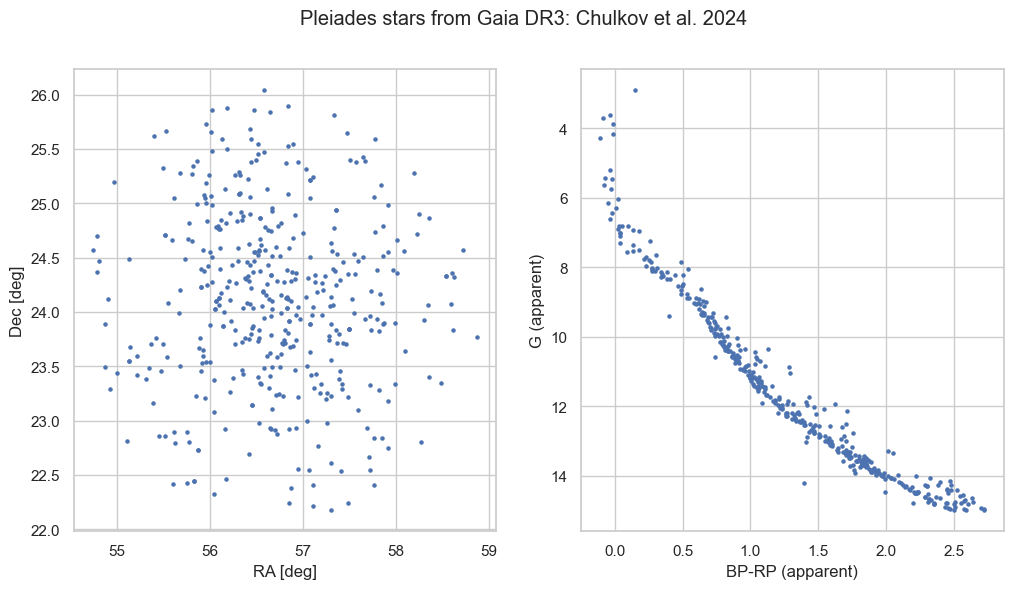

In [100]:
plotPath = "plots/"
if not os.path.exists(plotPath):
    os.makedirs(plotPath)

## Check plot:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Pleiades stars from Gaia DR3: Chulkov et al. 2024")
ax[0].scatter(df["ra"], df["dec"], s=5)
ax[0].set_xlabel("RA [deg]")
ax[0].set_ylabel("Dec [deg]")

ax[1].scatter(df["bp_rp"], df["phot_g_mean_mag"], s=5)
ax[1].set_ylabel("G (apparent)")
ax[1].set_xlabel("BP-RP (apparent)")
ax[1].invert_yaxis()

if save:
    fig.savefig(plotPath+"Pleiades_Gaia_DR3_Chulkov_et_al_2024.png", dpi=300)

### Calculating Mass 

In [101]:
## ISOCHRONE

# Read the first few lines to inspect structure
iso_data = 'DATA/output69089225567.dat'                 #output69089225567.dat is the one where a put an Av = 0.15 as the paper suggests
with open(iso_data, "r") as f:
    lines = f.readlines()

# Show the first 20 lines to understand header and column structure
lines[:30]

['# File generated by CMD 3.8 (http://stev.oapd.inaf.it/cmd) on Wed May 21 17:25:42 UTC 2025\n',
 '# isochrones based on PARSEC release v2.0 \n',
 '# Basic references: Costa et al. 2019a,2019b for the code, Nguyen et al. 2022 for the tracks.\n',
 '# Rotating tracks computed with omega_i=0.00, except for lower masses (see paper)\n',
 '# Thermal pulse cycles included \n',
 '# On RGB, assumed Reimers mass loss with efficiency eta=0.2\n',
 '# LPV periods and growth rates added cf. Trabucchi et al. (2019)\n',
 '# but fundamental-mode LPV periods + transition are from Trabucchi et al. (2021)\n',
 '# Photometric system: Gaia EDR3 (all Vegamags, Gaia passbands from ESA/Gaia website)\n',
 "# Attention: photometry includes extinction of Av=0.15, with coefficients derived star-by-star, for Cardelli et al 89 + O'Donnell 94 Rv=3.1 extinction curve.\n",
 '# Using YBC version of bolometric corrections as in Chen et al. (2019)\n',
 '# O-rich circumstellar dust ignored\n',
 '# C-rich circumstellar dust

In [102]:
# Find the header line (starts with "# Zini")
header_line_index = next(i for i, line in enumerate(lines) if line.startswith('# Zini'))

# Extract column names from the header line
column_names = lines[header_line_index].lstrip("#").strip().split()

# Read the data from the file using pandas, skipping the header lines
isochrone_df = pd.read_csv(
    iso_data,
    delim_whitespace=True,
    comment="#",
    names=column_names
)

# Select relevant CMD columns
iso_cmd_df = isochrone_df[["Mass", "G_BP_fSBmag", "G_fSBmag", "G_RP_fSBmag"]]
iso_cmd_df.head()

,Mass,G_BP_fSBmag,G_fSBmag,G_RP_fSBmag
0,0.090,16.719,13.868,12.353
1,0.096,16.593,13.740,12.225
2,0.100,16.475,13.645,12.135
3,0.106,16.289,13.509,12.007
4,0.114,15.915,13.262,11.783


C:\Users\bosca\AppData\Local\Temp\ipykernel_23624\2856367970.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iso_cmd_df["BP-RP fSBmag"] = iso_cmd_df["G_BP_fSBmag"].values - iso_cmd_df["G_RP_fSBmag"].values


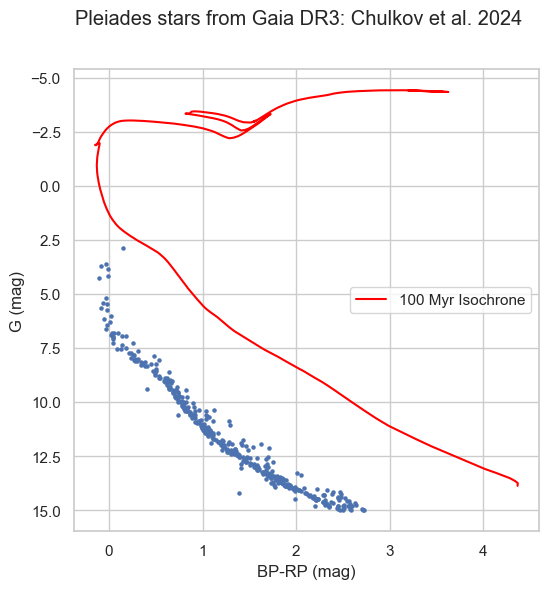

In [103]:
## plot against the data:

iso_cmd_df["BP-RP fSBmag"] = iso_cmd_df["G_BP_fSBmag"].values - iso_cmd_df["G_RP_fSBmag"].values
color_iso = iso_cmd_df["BP-RP fSBmag"].values
mag_iso = iso_cmd_df["G_fSBmag"]

fig, ax = plt.subplots(figsize=(6, 6))
fig.suptitle("Pleiades stars from Gaia DR3: Chulkov et al. 2024")

ax.scatter(df["bp_rp"], df["phot_g_mean_mag"], s=5)
ax.plot(color_iso, mag_iso, color='red', label='100 Myr Isochrone')
ax.set_ylabel("G (mag)")
ax.set_xlabel("BP-RP (mag)")
ax.invert_yaxis()
ax.legend(loc='center right')

In [104]:
# Extinction in Gaia bands (using Casagrande+ 2021, typical for AV = 0.15):

mu = 5.65                   # distance modulus for 135 pc
A_V = 0.15                  # extinction in V band
A_G = 0.789 * A_V           # extinction in G band
A_BP = 1.067 * A_V          # extinction in BP band
A_RP = 0.634 * A_V          # extinction in RP band

# Correct the magnitudes
iso_cmd_df["CORR G_fSBmag"] = iso_cmd_df["G_fSBmag"] + mu + A_G
iso_cmd_df["CORR G_BP_fSBmag"] = iso_cmd_df["G_BP_fSBmag"] + mu + A_BP
iso_cmd_df["CORR G_RP_fSBmag"] = iso_cmd_df["G_RP_fSBmag"] + mu + A_RP
iso_cmd_df['CORR BP-RP fSBmag'] = iso_cmd_df["CORR G_BP_fSBmag"].values - iso_cmd_df["CORR G_RP_fSBmag"].values

# isochrone cuts for pleiades stars

iso_pleiades = iso_cmd_df[
    (iso_cmd_df["CORR G_fSBmag"] < 16.0) &
    (iso_cmd_df["CORR G_fSBmag"] > 3.8) &
    (iso_cmd_df["CORR BP-RP fSBmag"] < 5.0) &
    (iso_cmd_df["CORR BP-RP fSBmag"] > - 0.5)
].copy()


C:\Users\bosca\AppData\Local\Temp\ipykernel_23624\3644795417.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iso_cmd_df["CORR G_fSBmag"] = iso_cmd_df["G_fSBmag"] + mu + A_G
C:\Users\bosca\AppData\Local\Temp\ipykernel_23624\3644795417.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iso_cmd_df["CORR G_BP_fSBmag"] = iso_cmd_df["G_BP_fSBmag"] + mu + A_BP
C:\Users\bosca\AppData\Local\Temp\ipykernel_23624\3644795417.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

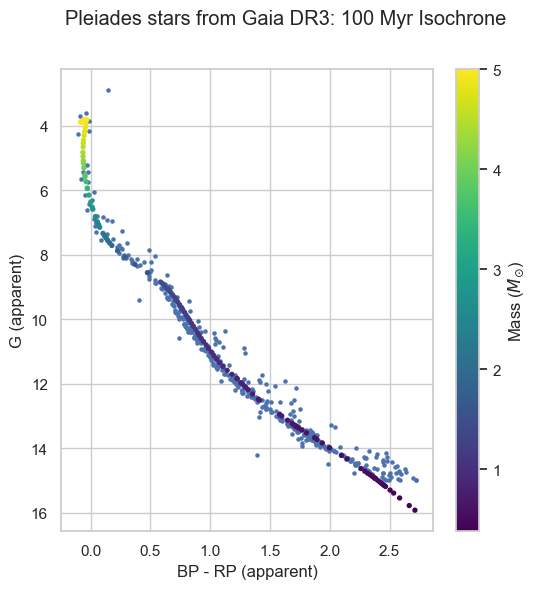

In [105]:
fig, ax = plt.subplots(figsize=(6, 6))
fig.suptitle("Pleiades stars from Gaia DR3: 100 Myr Isochrone")

ax.scatter(df['bp_rp'], df["phot_g_mean_mag"], s=5)
sc = ax.scatter(iso_pleiades['CORR BP-RP fSBmag'], iso_pleiades["CORR G_fSBmag"].values, c=iso_pleiades["Mass"], cmap='viridis', s=8, label='Isochrone (100 Myr)')
ax.set_xlabel("BP - RP (apparent)")
ax.set_ylabel("G (apparent)")
ax.invert_yaxis()
legend = ax.legend(loc='upper right')
legend.remove()  # Remove legend for scatter, as colorbar is more informative

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label(r"Mass ($M_{\odot}$)")

if save:
    fig.savefig(plotPath+"Pleiades_Gaia_DR3_Chulkov_et_al_2024_isochrone.png", dpi=300)

In [106]:
## good, now we assigne the mass from the isochrone for each stars in Gaia dataframe

def assign_mass(row, iso_df):
    # Find the closest mass in the isochrone data
    closest_mass = iso_df.iloc[(iso_df['CORR BP-RP fSBmag'] - row['bp_rp']).abs().argsort()[:1]]['Mass'].values[0]
    return closest_mass


def interpolate_mass(color, magnitude, isochrone_data):
    # Find the closest match in the isochrone data (interpolation can be used if necessary)
    # Assuming the isochrone data has columns [Mass, Color, Magnitude]
    masses = isochrone_data[:, 0]
    colors = isochrone_data[:, 1] - isochrone_data[:, 3] # Color column (adjust index based on file structure)
    magnitudes = isochrone_data[:, 2]  # Magnitude column (adjust index based on file structure)

    # Find the index of the closest color and magnitude
    idx = np.argmin(np.sqrt((colors - color)**2 + (magnitudes - magnitude)**2))
    
    return masses[idx]

# Monte Carlo Simulation to estimate mass error
def monte_carlo_mass_error(star_data, isochrone_data, n_samples=1000):
    color, magnitude, color_error, magnitude_error = star_data
    masses = []
    
    for _ in range(n_samples):
        # Sample color and magnitude within their uncertainties
        sampled_color = np.random.normal(color, color_error)
        sampled_magnitude = np.random.normal(magnitude, magnitude_error)
        
        # Estimate mass for the sampled values
        mass = interpolate_mass(sampled_color, sampled_magnitude, isochrone_data)
        masses.append(mass)
    
    # Calculate the standard deviation of the mass estimates
    mass_error = np.std(masses)
    
    return mass_error


df['mass'] = df.apply(lambda row: assign_mass(row, iso_pleiades), axis=1)
print(f"Number of stars in the Pleiades with radial velocity and mass: {len(df)}")


#mass_error = monte_carlo_mass_error(df['bp-rp', 'phot_g_mean_mag', ''], isochrone_data)
#print("Mass error:", mass_error)

C:\Users\bosca\AppData\Local\Temp\ipykernel_23624\2496107573.py:5: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  closest_mass = iso_df.iloc[(iso_df['CORR BP-RP fSBmag'] - row['bp_rp']).abs().argsort()[:1]]['Mass'].values[0]
C:\Users\bosca\AppData\Local\Temp\ipykernel_23624\2496107573.py:5: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  closest_mass = iso_df.iloc[(iso_df['CORR BP-RP fSBmag'] - row['bp_rp']).abs().argsort()[:1]]['Mass'].values[0]
C:\Users\bosca\AppData\Local\Temp\ipykernel_23624\2496107573.py:5: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  closest_mass = iso_df.iloc[(iso_df['CORR BP-RP fSBmag'] - row['bp_rp']).abs().a

Number of stars in the Pleiades with radial velocity and mass: 423


C:\Users\bosca\AppData\Local\Temp\ipykernel_23624\2496107573.py:5: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  closest_mass = iso_df.iloc[(iso_df['CORR BP-RP fSBmag'] - row['bp_rp']).abs().argsort()[:1]]['Mass'].values[0]
C:\Users\bosca\AppData\Local\Temp\ipykernel_23624\2496107573.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mass'] = df.apply(lambda row: assign_mass(row, iso_pleiades), axis=1)


In [107]:
df.head(10)

,source_id,ref_epoch,ra,dec,ra_error,dec_error,ra_dec_corr,parallax,parallax_error,pmra,...,radial_velocity,radial_velocity_error,has_epoch_rv,ipd_frac_multi_peak,ipd_gof_harmonic_amplitude,astrometric_chi2_al,astrometric_n_good_obs_al,ruwe,duplicated_source,mass
0,65588484235454592,2016.0,58.268967,22.801153,0.013425,0.008666,-0.124594,7.293433,0.014909,19.036700,...,6.250218,0.944959,False,0,0.025033,352.88670,329,1.044438,False,0.695
1,65641913628380288,2016.0,58.488726,23.345105,0.021880,0.012707,0.022201,7.415903,0.022449,20.241861,...,19.819576,3.596542,False,0,0.037106,684.19150,363,1.425352,False,0.600
2,65660158649542784,2016.0,57.908559,23.182920,0.214735,0.123755,0.108511,7.656667,0.237372,23.660945,...,6.110118,2.084974,False,0,0.016865,113344.97000,429,13.699448,False,0.661
3,65673593307063552,2016.0,57.816005,23.282072,0.018949,0.011151,-0.086201,7.391214,0.019583,20.266120,...,-1.554802,4.088157,False,0,0.036792,482.27945,447,1.075288,False,0.557
4,65677372878285312,2016.0,57.714441,23.328869,0.014915,0.008545,0.050938,7.333805,0.016010,18.888363,...,6.402642,0.464261,False,0,0.043562,832.00635,419,1.130002,False,0.816
5,65680499614460800,2016.0,57.989008,23.339221,0.014527,0.008449,0.101453,7.484240,0.014865,20.844311,...,5.429410,1.014421,False,0,0.024680,648.59180,418,1.072775,False,0.747
6,65690498298435840,2016.0,58.353538,23.403957,0.047446,0.027588,-0.011887,7.539437,0.049088,20.973390,...,0.197040,4.820275,False,0,0.017866,2971.08720,338,3.085630,False,0.513
7,65712488530853120,2016.0,58.093865,23.644663,0.016725,0.008423,-0.028021,7.842320,0.016345,20.351204,...,8.562927,2.124587,False,0,0.081661,390.80020,380,1.052246,False,0.614
8,65750627840192256,2016.0,58.870949,23.772242,0.014308,0.008699,0.007505,7.250917,0.015259,17.759083,...,0.921870,2.339711,False,0,0.027942,462.76154,394,1.120992,False,0.634
9,65800930496992512,2016.0,58.616589,23.835175,0.013759,0.008399,-0.044843,7.622050,0.014964,19.623070,...,2.231457,8.190568,False,0,0.021413,555.91156,357,1.091179,False,0.661


In [108]:
if save:
    df.to_csv("DATA/My_Pleiades_filtered_Gaia_DR3_with_mass.csv", index=False)

In [109]:
print(df['radial_velocity'].isna().sum())
print(df['parallax'].isna().sum())

51
16


## Finding the source is the RV papers

In [110]:
from astropy.table import Table


RV_data = Table.read('DATA/radial_velocity_single_lined_objects.fit').to_pandas()
ID_list = Table.read('DATA/list_analyzed_object_radial_velocities.fit').to_pandas()

print(RV_data.shape, ID_list.shape)
print(RV_data.columns, ID_list.columns)
ID_list.head(10)

(4631, 8) (377, 11)
Index(['Seq', 'Name', 'HJD', 'RVel', 'e_RVel', 'S_N', 'Inst', 'recno'], dtype='object') Index(['Seq', 'Name', 'RA_ICRS', 'DE_ICRS', 'Gaia', 'Gmag', 'plx', 'e_plx',
       'pmRA', 'e_pmRA', 'recno'],
      dtype='object')


,Seq,Name,RA_ICRS,DE_ICRS,Gaia,Gmag,plx,e_plx,pmRA,e_pmRA,recno
0,1,b'AK III-31',51.88537,25.89995,117280133627745280,9.05,13.737,0.021,16.513,0.023,1
1,2,b'PELS 121',51.92529,23.80351,68711956249760768,10.13,5.237,0.015,4.479,0.016,2
2,3,b'PELS 1',52.06861,22.64106,61842035801405824,10.41,2.281,0.049,15.006,0.050,3
3,4,b'AK III-59',52.16877,25.60767,69221506874062720,11.51,6.334,0.020,24.659,0.025,4
4,5,b'AK III-79',52.35599,25.65215,69595035885590144,9.33,7.318,0.017,31.053,0.019,5
5,6,b'AK III-158',52.80562,26.43951,69659730977217792,9.12,10.624,0.021,15.011,0.025,6
6,7,b'AK III-153',52.81658,25.25526,69335619861034752,8.09,7.617,0.033,22.625,0.037,7
7,8,b'AK III-170',52.89021,26.26528,69643757994608512,10.58,6.923,0.018,20.649,0.018,8
8,9,b'AK II-131',53.27437,22.13405,61554650949438208,11.21,7.558,0.019,22.183,0.025,9
9,10,b'AK II-138',53.30801,23.00623,67680850564641792,11.69,7.941,0.014,22.730,0.016,10


In [111]:
## find the RV sources that are in the Pleiades dataframe
ID_list_pleiades = ID_list[ID_list['Gaia'].isin(df['source_id'])]

print(ID_list_pleiades.shape)
print(df.shape)

(256, 11)
(423, 27)


In [ ]:
## Now we find which star has a significant radial velocity changes over time

def find_significant_rv_changes(rv_data, id_list):
    names = []
    for index, row in id_list.iterrows():
        name = row['Name']
        if name in rv_data['Name'].values:
            rv_values = rv_data[rv_data['Name'] == name]['RVel'].values
            rv_errors = rv_data[rv_data['Name'] == name]['e_RVel'].values
            if len(rv_values) > 1:
                # See if the radial velocity changes significantly
                if np.std(rv_values) > 3 * np.mean(rv_errors):
                    names.append(name)
    return names

significant_rv_stars = find_significant_rv_changes(RV_data, ID_list_pleiades)
print(f"Number of stars with significant radial velocity changes: {len(significant_rv_stars)}")

# find the corresponding source_ids in the Pleiades dataframe
def find_source_ids_by_names(df, names):
    source_ids = []
    for name in names:
        if name in df['Name'].values:
            source_id = df[df['Name'] == name]['Gaia'].values[0]
            source_ids.append(source_id)
    return source_ids

source_ids_significant_rv = find_source_ids_by_names(ID_list_pleiades, significant_rv_stars)
print(f"Number of source_ids with significant radial velocity changes: {len(source_ids_significant_rv)}")

significant_rv_stars_df = pd.DataFrame({
    'Name': significant_rv_stars,
    'source_id': source_ids_significant_rv
})

if save:
    significant_rv_stars_df.to_csv("DATA/Pleiades_significant_rv_stars.csv", index=False)

significant_rv_stars_df.head(20)


Number of stars with significant radial velocity changes: 17


TypeError: list indices must be integers or slices, not tuple

## From Resolving Pleiades Binary paper

Here where simulate the same method of the Section 5

### Step 1: Find Close Gaia Pairs for each of significally RV stars

- Use a search radius ≤ 10 arcsec.

- For each source, check if there's a Gaia neighbor within that radius.

### Step 2: For Each Pair:
Extract proper motions of both stars.

Compute: Relative proper motion (δµ) and Parallax difference (∆ϖ/σ)

If δµ < 10 mas/yr and ∆ϖ/σ is small → likely a physical binary.

In [86]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from itertools import combinations

def angular_separation(ra1, dec1, ra2, dec2):
    c1 = SkyCoord(ra1*u.deg, dec1*u.deg)
    c2 = SkyCoord(ra2*u.deg, dec2*u.deg)
    return c1.separation(c2).arcsec


def compute_binary_params(s1, s2):    
    delta_pmra = s1['pmra'] - s2['pmra']
    delta_pmdec = s1['pmdec'] - s2['pmdec']
    delta_mu = np.sqrt(delta_pmra**2 + delta_pmdec**2)

    delta_parallax = abs(s1['parallax'] - s2['parallax'])
    sigma_parallax = np.sqrt(s1['parallax_error']**2. + s2['parallax_error']**2.) 
    delta_parallax_sigma = delta_parallax / sigma_parallax

    return delta_mu, delta_parallax_sigma

# Step 1: Find candidate pairs within 10 arcsec
pairs = []
for id in significant_rv_stars_df['source_id']:
    current_star = df[df['source_id'] == id].iloc[0]
    for i, neighbor_star in df.iterrows():
        if neighbor_star['source_id'] != id:
            sep = angular_separation(current_star['ra'], current_star['dec'], neighbor_star['ra'], neighbor_star['dec'])
            if sep <= 10:
                delta_mu, delta_parallax_sigma = compute_binary_params(current_star, neighbor_star)
                if current_star['mass'] > neighbor_star['mass']:
                    q = current_star['mass'] / neighbor_star['mass']
                else:
                    q = neighbor_star['mass'] / current_star['mass']
                pairs.append({
                    'primary_id': current_star['source_id'],
                    'secondary_id': neighbor_star['source_id'],
                    'sep_arcsec': sep,
                    'delta_mu': delta_mu,
                    'delta_parallax_sigma': delta_parallax_sigma,
                    'primary_mass': current_star['mass'],
                    'secondary_mass': neighbor_star['mass'],
                    'mass ratio (q)': q,
                })

pairs_df = pd.DataFrame(pairs)

In [87]:
print(pairs_df.shape)
pairs_df.head(20)

(2, 8)


,primary_id,secondary_id,sep_arcsec,delta_mu,delta_parallax_sigma,primary_mass,secondary_mass,mass ratio (q)
0,65207709611941376,65207709613871744,6.274134,2.241359,0.557441,2.600,1.163,2.235598
1,66507469798632320,66507469798631936,6.828030,4.595541,1.135834,1.067,5.001,4.686973


In [88]:
# Dividing into two dataframes: one with pairs from Chulkov et al. 2024 and one with the rest
primary_members_df = df[df['source_id'].isin(pairs_df['primary_id'])].copy()
secondary_members_df = df[df['source_id'].isin(pairs_df['secondary_id'])].copy()

primary_members_df.reset_index(inplace=True, drop=True)
secondary_members_df.reset_index(inplace=True, drop=True)

print(primary_members_df.shape)
print(secondary_members_df.shape)

(2, 27)
(2, 27)


Now let's visualize the dataframe of both member with the orbital feature that we need

In [89]:
orbital_features = ['source_id', 'ref_epoch', 'ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity', 'mass', 'ra_error', 'dec_error', 'pmra_error', 'pmdec_error', 'parallax_error', 'radial_velocity_error', 'has_epoch_rv']

primary_members_df_orbits = primary_members_df[orbital_features]
secondary_members_df_orbits = secondary_members_df[orbital_features]

primary_members_df_orbits.head(20)

,source_id,ref_epoch,ra,dec,pmra,pmdec,parallax,radial_velocity,mass,ra_error,dec_error,pmra_error,pmdec_error,parallax_error,radial_velocity_error,has_epoch_rv
0,66507469798632320,2016.0,57.489468,23.846882,21.530787,-43.565036,7.642781,0.934193,1.067,0.245120,0.135241,0.280003,0.176236,0.245663,2.455118,False
1,65207709611941376,2016.0,56.851821,23.914478,20.049108,-44.132590,7.220987,-1.856786,2.600,0.030519,0.022987,0.041599,0.029272,0.034383,2.441681,False


In [90]:
secondary_members_df_orbits.head(20)

,source_id,ref_epoch,ra,dec,pmra,pmdec,parallax,radial_velocity,mass,ra_error,dec_error,pmra_error,pmdec_error,parallax_error,radial_velocity_error,has_epoch_rv
0,66507469798631936,2016.0,57.491184,23.847947,21.026666,-48.132843,7.361154,4.707757,5.001,0.033703,0.018977,0.038665,0.025343,0.033577,0.533899,False
1,65207709613871744,2016.0,56.849928,23.914271,19.605919,-46.329695,7.185576,5.368229,1.163,0.046900,0.036556,0.060045,0.044302,0.053416,0.577683,False


In [91]:
print(RV_data[RV_data['Name'] == significant_rv_stars_df.iloc[9,0]]) 

      Seq         Name         HJD       RVel  e_RVel  S_N  Inst  recno
2990  235  b'HII 1397'  52508.8583  18.840000    0.45   28     1   2991
2991  235  b'HII 1397'  52508.8824  18.840000    0.49   23     1   2992
2992  235  b'HII 1397'  52569.7628   8.500000    0.56   21     1   2993
2993  235  b'HII 1397'  52636.4998   3.900000    0.66   16     1   2994
2994  235  b'HII 1397'  52651.6359  -1.700000    0.57   17     1   2995
2995  235  b'HII 1397'  52683.6160   3.520000    0.70   18     1   2996
2996  235  b'HII 1397'  52713.5468   9.580000    0.64   17     1   2997
2997  235  b'HII 1397'  52959.6351   2.800000    0.41   29     1   2998
2998  235  b'HII 1397'  52977.6046   6.170000    0.43   23     1   2999
2999  235  b'HII 1397'  52977.6083   5.820000    0.83   16     1   3000
3000  235  b'HII 1397'  52992.6886  11.370000    0.56   18     1   3001
3001  235  b'HII 1397'  53003.6540   3.070000    0.44   22     1   3002
3002  235  b'HII 1397'  53022.5420  16.240000    0.52   19     1

In [92]:
from matplotlib import cm

# Generate 20 well-separated colors from the 'viridis' colormap
num_colors = len(primary_members_df_orbits)
colors = [cm.tab20(i / num_colors) for i in range(num_colors)]

# Example usage: print the colors
print(colors)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0)]


C:\Users\bosca\AppData\Local\Temp\ipykernel_23624\4060406753.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0].scatter([primary_members_df.iloc[i]['ra'], secondary_members_df.iloc[i]['ra']],
C:\Users\bosca\AppData\Local\Temp\ipykernel_23624\4060406753.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[1].scatter([primary_members_df.iloc[i]['bp_rp'], secondary_members_df.iloc[i]['bp_rp']],


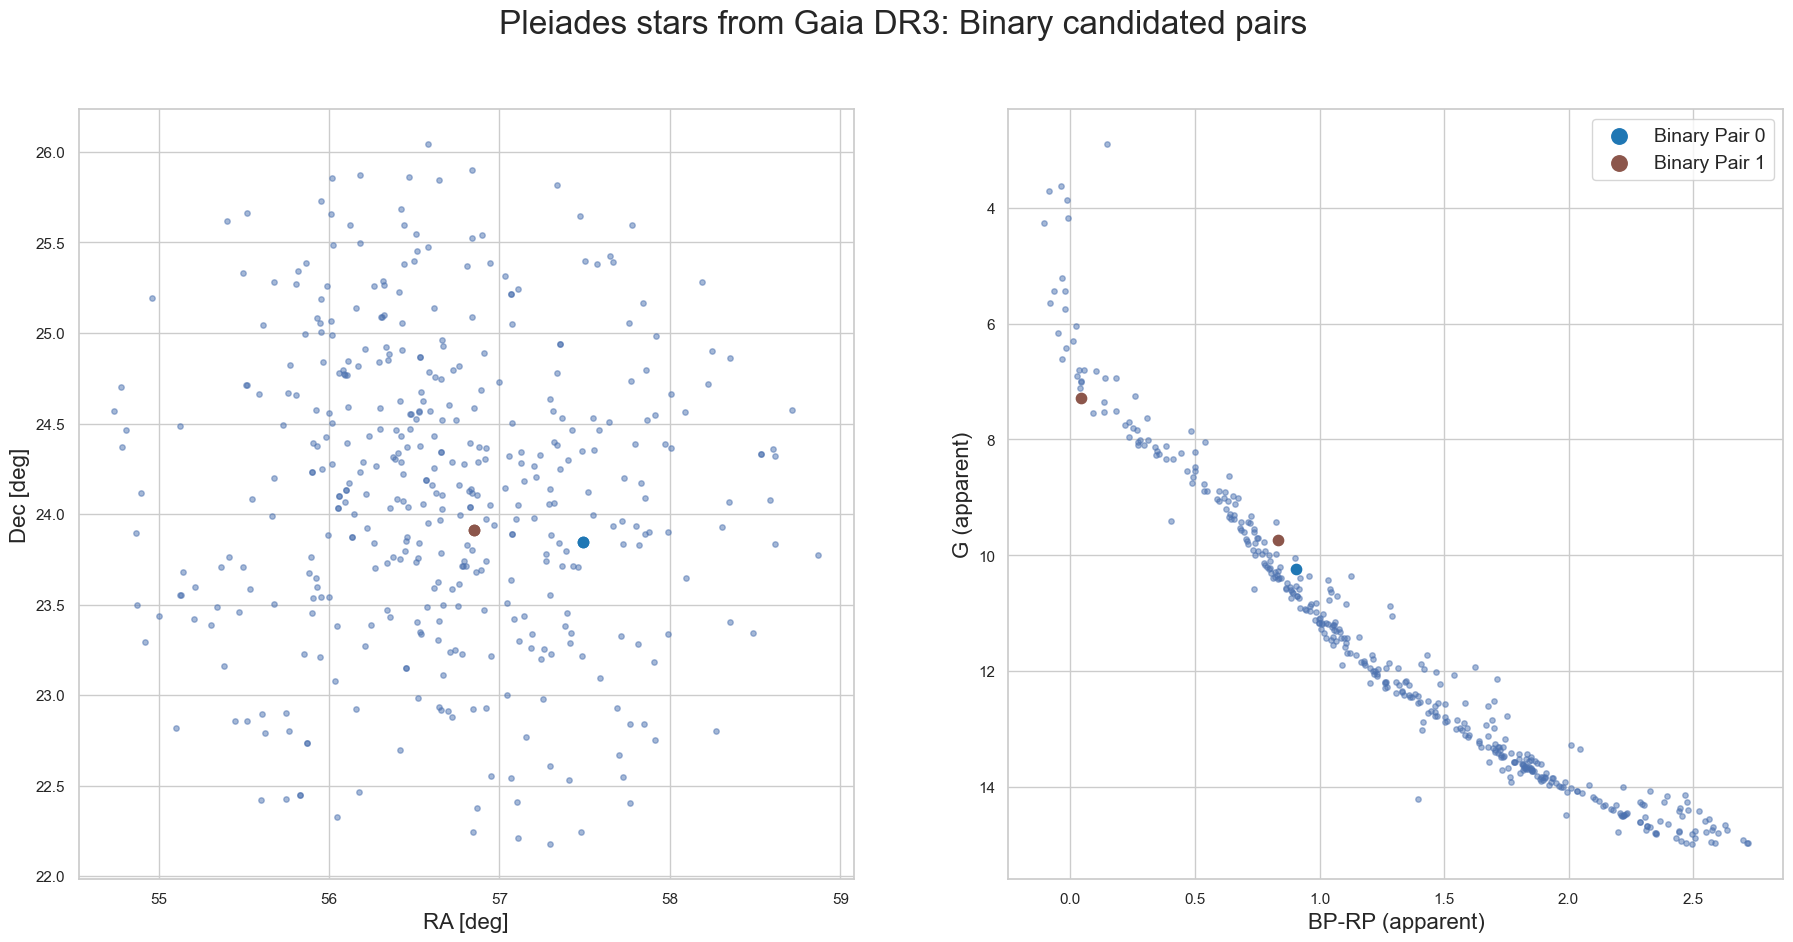

In [93]:
## Check plot:
fig, ax = plt.subplots(1, 2, figsize=(22, 10))
fig.suptitle("Pleiades stars from Gaia DR3: Binary candidated pairs", fontsize=24)
ax[0].scatter(df["ra"], df["dec"], s=15, alpha=0.5)
for i in range(len(primary_members_df)):
    ax[0].scatter([primary_members_df.iloc[i]['ra'], secondary_members_df.iloc[i]['ra']],
                  [primary_members_df.iloc[i]['dec'], secondary_members_df.iloc[i]['dec']],
                  alpha=1.0, s=55, label=f'Binary Pair {i}', c=colors[i])
ax[0].set_xlabel("RA [deg]", fontsize=16)
ax[0].set_ylabel("Dec [deg]", fontsize=16)

ax[1].scatter(df["bp_rp"], df["phot_g_mean_mag"], s=15, alpha=0.5)
for i in range(len(primary_members_df)):
    ax[1].scatter([primary_members_df.iloc[i]['bp_rp'], secondary_members_df.iloc[i]['bp_rp']],
                  [primary_members_df.iloc[i]['phot_g_mean_mag'], secondary_members_df.iloc[i]['phot_g_mean_mag']],
                  alpha=1.0, s=55, label=f'Binary Pair {i}', c=colors[i])
ax[1].set_ylabel("G (apparent)", fontsize=16)
ax[1].set_xlabel("BP-RP (apparent)", fontsize=16)
ax[1].invert_yaxis()
ax[1].legend(loc='upper right', fontsize=14, markerscale=1.5)

#if save:
    #fig.savefig(plotPath+"Pleiades_binary_pairs_Gaia_DR3.png", dpi=300)

Now for calculate the orbitals of the binaries we need al the astronometric information as radial velocity and parallax.
let's filter our pairs catalogues

In [94]:
# Save both members_df

if save:
    primary_members_df.to_csv('DATA/primary_members_df_orbits_only2.csv', index=False)
    secondary_members_df.to_csv('DATA/secondary_members_df_orbits_only2.csv', index=False)